## Predicting Airline Delays<br>

Notebook: Data Modeling
  
Team: Jimmy Nguyen, Maha Jayapal, Roberto Cancel<br>

## Packages 

In [1]:
#!pip install --upgrade numpy #ensure numpy and pandas are upgraded to same versions for easier exploration (avoiding errors)
#!pip install --upgrade pandas #ensure numpy and pandas are upgraded to same versions for easier exploration (avoiding errors)
#!pip install xgboost


import tarfile
import pickle as pkl
import boto3
import sagemaker
from sagemaker import image_uris
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
import io # for encoding issues with raw data sets
from io import StringIO # converting dataframe to csv and uploading to s3 bucket /tranformed folder

import pandas as pd
import numpy as np
import xgboost
from xgboost import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
import pickle as pkl
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

## Set-up 

In [2]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [3]:
print("Default bucket: {}".format(bucket))

Default bucket: sagemaker-us-east-1-957093009964


## Train, Validation, and Test Data 

In [4]:
s3_client = boto3.resource('s3')

# training data
BUCKET = 'ads-508-airline'
KEY = "model_data/df_train.csv"

response = s3_client.Object(BUCKET, KEY)
train = pd.read_csv(response.get()['Body'])
train.head()

,DEP_DEL15,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND,WEEK_OF_MONTH
0,1.0,3,3,4,2840,4905,3888,726,0.00,0.0,0.0,50.0,1.57,4
1,1.0,3,3,4,2444,23,2273,787,0.29,0.9,1.2,41.0,12.30,2
2,1.0,4,4,7,7637,16888,15237,4991,0.00,0.0,1.2,27.0,14.99,3
3,1.0,7,4,5,5175,1407,4076,2145,0.04,0.0,0.0,67.0,16.11,1
4,0.0,5,2,4,7637,16888,15237,4991,0.00,0.0,0.0,57.0,2.01,4


In [5]:
# validation data
KEY = "model_data/df_val.csv"

response = s3_client.Object(BUCKET, KEY)
valid = pd.read_csv(response.get()['Body'])
valid.head()

,DEP_DEL15,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND,WEEK_OF_MONTH
0,0.0,1,2,4,8989,9668,15475,2482,0.0,0.0,0.0,42.0,8.05,1
1,1.0,4,3,4,8989,9668,15475,2482,0.0,0.0,0.0,60.0,5.82,3
2,0.0,5,4,3,8989,9668,15475,2482,0.0,0.0,0.0,61.0,2.68,1
3,1.0,2,3,8,8989,9668,15475,2482,0.0,0.0,0.0,55.0,2.91,4
4,0.0,7,2,2,8989,9668,15475,2482,0.0,0.0,0.0,52.0,9.84,4


In [6]:
# Test data
KEY = "model_data/df_test.csv"

response = s3_client.Object(BUCKET, KEY)
test = pd.read_csv(response.get()['Body'])
test.head()

,DEP_DEL15,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND,WEEK_OF_MONTH
0,1.0,1,2,5,8989,9668,15475,2482,0.0,0.0,0.0,53.0,3.36,5
1,0.0,4,3,6,7637,16888,15237,4991,0.0,0.0,0.0,68.0,4.70,4
2,1.0,4,4,4,8989,9668,15475,2482,0.0,0.0,0.0,80.0,9.40,4
3,1.0,6,3,3,8989,9668,15475,2482,0.0,0.0,0.0,41.0,7.61,1
4,0.0,2,2,5,8586,8586,15502,9677,0.0,0.0,0.0,50.0,9.17,3


## S3 Data Inputs for Modeling 

In [7]:
# Training data
KEY = "model_data/df_train.csv"
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}'.format(BUCKET, KEY), content_type='csv')
s3_input_train

In [8]:
# Validation data
KEY = "model_data/df_val.csv"
s3_input_valid = sagemaker.TrainingInput(s3_data='s3://{}/{}'.format(BUCKET,KEY), content_type='csv')

In [9]:
# Test data
KEY = "model_data/df_test.csv"
s3_input_test = sagemaker.TrainingInput(s3_data='s3://{}/{}'.format(BUCKET, KEY), content_type='csv')

## Modeling - XGBOOST

In [10]:
# initialize hyperparameters
hyperparameters = {
        "max_depth":"5", #default 6 - reduced to reduce complexity and overfitting
        "eta":"0.3", #default
        "gamma":"0", #default
        "min_child_weight":"1", #default
        "subsample":"0.5", #optimized to prevent overfitting
        "lambda":"1", #default
        "objective":"binary:logistic",
        "num_round":"50", "eval_metric":"auc"}

# set an output path where the trained model will be saved
bucket = sagemaker.Session().default_bucket()
prefix = 'baseline_model'
output_path = 's3://{}/{}/{}/output'.format(bucket, prefix, 'xgb-built-in-algo')

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
# specify the repo_version depending on your preference.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", region, "1.2-2")

# construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1, 
                                          instance_type='ml.m5.large', 
                                          volume_size=5, # 5 GB 
                                          output_path=output_path)

# define the data type and paths to the training and validation datasets
content_type = "libsvm"

# execute the XGBoost training job
estimator.fit({'train': s3_input_train, 'validation': s3_input_valid})

2022-03-31 00:49:48 Starting - Starting the training job...
2022-03-31 00:50:16 Starting - Preparing the instances for trainingProfilerReport-1648687788: InProgress
.........
2022-03-31 00:51:36 Downloading - Downloading input data......
2022-03-31 00:52:37 Training - Downloading the training image.....[2022-03-31 00:53:31.040 ip-10-0-133-212.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-03-31:00:53:31:INFO] Imported framework sagemaker_xgboost_container.training
[2022-03-31:00:53:31:INFO] Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
[2022-03-31:00:53:31:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2022-03-31:00:53:31:INFO] No GPUs detected (normal if no gpus installed)
[2022-03-31:00:53:31:INFO] Running XGBoost Sagemaker in algorithm mode
[2022-03-31:00:53:31:INFO] Determined delimiter of CSV input is ','
[2022-03-31:00:53:31:INFO] Determined delimiter 

## Evaluation 

In [13]:

# download the model artifact from AWS S3
!aws s3 cp s3://sagemaker-us-east-1-957093009964/baseline_model/xgb-built-in-algo/output/sagemaker-xgboost-2022-03-31-00-49-48-555/output/model.tar.gz .
    
#opens the downloaded model artifcat and loads it as 'model' variable
tar = tarfile.open('model.tar.gz')
tar.extractall()
tar.close()
model = pkl.load(open('xgboost-model', 'rb'))

download: s3://sagemaker-us-east-1-957093009964/baseline_model/xgb-built-in-algo/output/sagemaker-xgboost-2022-03-31-00-49-48-555/output/model.tar.gz to ./model.tar.gz


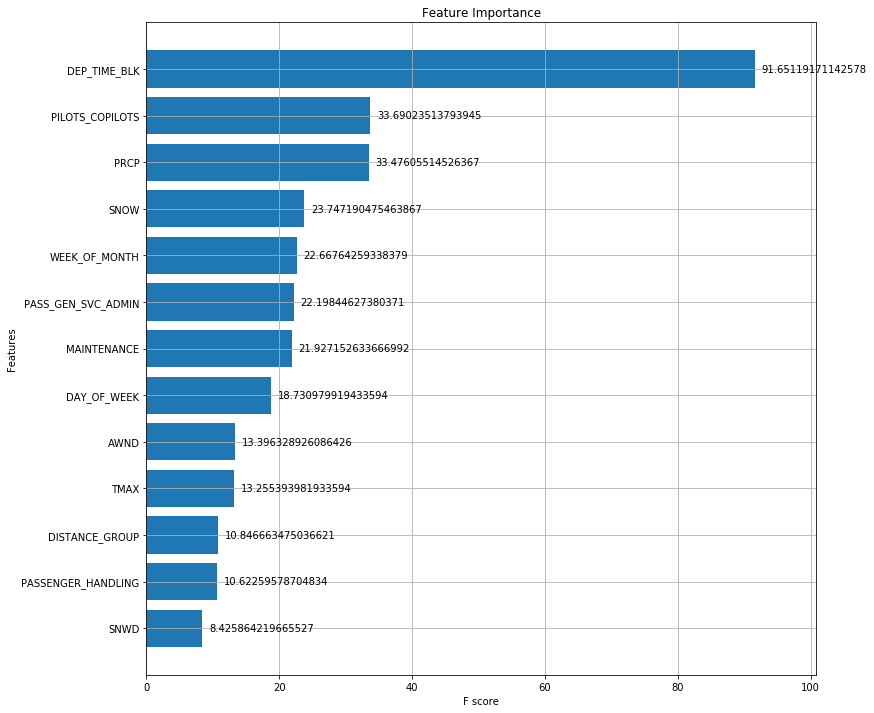

In [14]:
cols_input = ['DAY_OF_WEEK', 'DEP_TIME_BLK', 'DISTANCE_GROUP',
       'PILOTS_COPILOTS', 'PASSENGER_HANDLING', 'PASS_GEN_SVC_ADMIN',
       'MAINTENANCE', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND', 'WEEK_OF_MONTH']

# Match up with feature names 
map_names = dict(zip(list(model.get_fscore().keys()), train[cols_input].columns))
model.feature_names = list(map_names.values())

#plot feature importance
fig, ax = plt.subplots(figsize=(12,12))
xgboost.plot_importance(model, importance_type='gain', max_num_features=30, height=0.8, ax=ax, show_values = True)
plt.title('Feature Importance')
plt.show()